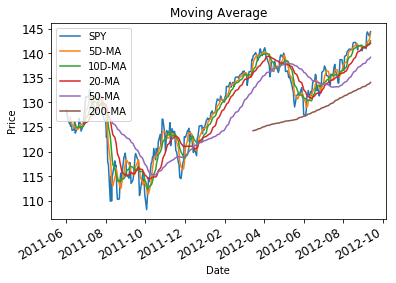

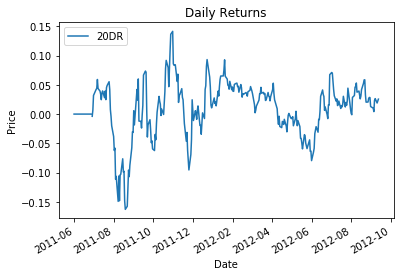

             MA-50    High     Low     SPY  20DR   MA-10   MA-20  MA-200
2011-08-31  123.14  123.51  121.30  119.68 -0.03  114.95  115.13     NaN
2011-09-01  122.99  123.40  120.78  118.42  0.01  115.58  115.17     NaN
2011-09-15  120.80  121.47  119.40  118.90  0.01  116.16  115.55     NaN
2011-09-16  120.54  121.97  120.32  119.61  0.07  116.28  115.93     NaN
2011-09-19  120.28  120.93  118.72  118.42  0.07  116.58  116.33     NaN
2011-09-20  120.06  121.99  120.01  118.28  0.07  116.95  116.73     NaN
2011-09-21  119.78  120.60  116.44  114.79  0.01  116.65  116.77     NaN
2011-09-27  118.56  119.56  116.84  115.69 -0.03  115.98  116.22     NaN
2011-09-28  118.22  118.49  114.97  113.33 -0.05  115.63  115.93     NaN
2011-10-06  116.00  116.66  113.51  114.66 -0.02  112.68  114.39     NaN
2011-10-07  115.73  117.25  115.06  113.89  0.00  112.90  114.41     NaN
2011-11-21  118.95  120.35  118.65  117.78 -0.05  122.19  122.81     NaN
2011-11-22  118.99  120.10  118.52  117.31 -0.03  1

In [15]:
"""Moving Average."""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def symbol_to_path(symbol, base_dir="C:\\Users\\ppadayac\\"):    #"C:\\Users\\ppadayac\\"
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close','High','Low'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])

    return df



def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    #return pd.rolling_mean(values, window=window)
    return pd.Series(values).rolling(window=window).mean()


def compute_daily_returns(df,n=1):
    """Compute and return the daily return values."""
    df_daily_ret = (df/df.shift(n)) -1
    # Note: Returned DataFrame must have the same number of rows
    #df_daily_ret.ix[0,:] = 0
    df_daily_ret.loc[df_daily_ret.index[0:(n-1)],:]= 0
    return df_daily_ret


def test_run():
    # Read data
    dates = pd.date_range('2011-06-01', '2012-12-31')
    symbols = ['SPY']
    df = get_data(symbols, dates)


    # 1. Compute rolling mean
    rm_SPY_5 = get_rolling_mean(df['SPY'], window=5)
    rm_SPY_10 = get_rolling_mean(df['SPY'], window=10)
    rm_SPY_20 = get_rolling_mean(df['SPY'], window=20)
    rm_SPY_50 = get_rolling_mean(df['SPY'], window=50)
    rm_SPY_200 = get_rolling_mean(df['SPY'], window=200)

    
    # Compute daily returns
    days_20_returns = compute_daily_returns(df[['SPY']],20)
    
    # Plot raw SPY values, rolling mean
    ax = df['SPY'].plot(title="Moving Average", label='SPY', fontsize=12)
    rm_SPY_5.plot(label='5D-MA', ax=ax)
    rm_SPY_10.plot(label='10D-MA', ax=ax)
    rm_SPY_20.plot(label='20-MA', ax=ax)
    rm_SPY_50.plot(label='50-MA', ax=ax)
    rm_SPY_200.plot(label='200-MA', ax=ax)

    
    days_20_returns.rename(columns={'SPY': '20DR'}, inplace=True)
    
    ay = days_20_returns.plot(title="Daily Returns", label='Daily Returns')
    
    ay.set_xlabel("Date")
    ay.set_ylabel("Price")
    ay.legend(loc='upper left')
    
    # Add axis labels and legend
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()
    
    rm_SPY_5 = rm_SPY_5.to_frame('MA-5')
    rm_SPY_10 = rm_SPY_10.to_frame('MA-10')
    rm_SPY_20 = rm_SPY_20.to_frame('MA-20')
    rm_SPY_50 = rm_SPY_50.to_frame('MA-50')
    rm_SPY_200 = rm_SPY_200.to_frame('MA-200')
    
    rm_SPY_50 = rm_SPY_50.dropna()
    rm_SPY_50 = rm_SPY_50.join(df,how='inner')
    
    rm_SPY_50['MA-50'] = np.where(
        (rm_SPY_50['MA-50'] >= rm_SPY_50['Low']) &
        (rm_SPY_50['MA-50'] <= rm_SPY_50['High'])
        ,rm_SPY_50['MA-50'],0)
    
    rm_SPY_50.rename(columns={'MA-50': 'MA_fifty'}, inplace=True)
    rm_SPY_50 = rm_SPY_50[rm_SPY_50.MA_fifty != 0]
    rm_SPY_50.rename(columns={'MA_fifty': 'MA-50'}, inplace=True)
    
    
    rm_SPY_50 = rm_SPY_50.join(days_20_returns,how='inner')
    #rm_SPY_50 = rm_SPY_50.join(rm_SPY_5,how='inner')
    rm_SPY_50 = rm_SPY_50.join(rm_SPY_10,how='inner')
    rm_SPY_50 = rm_SPY_50.join(rm_SPY_20,how='inner')
    rm_SPY_50 = rm_SPY_50.join(rm_SPY_200,how='inner')
    print(rm_SPY_50.round(2))

    
if __name__ == "__main__":
    test_run()